In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from pandas.tseries.offsets import MonthEnd

pd.options.display.float_format = '{:.6f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
companies = pd.read_csv('companies.csv', parse_dates=['first_bought', 'sold_out'])
edgar = pd.read_csv('edgar.csv', parse_dates=['date'])
ezv = pd.read_csv('ezv/ezv.wide.csv', parse_dates=['date'], index_col=['date']).resample('D').ffill()
ydata_usd = pd.read_feather('ydata_usd.feather').set_index('Date')
fundsmith_t_inc = pd.read_csv('t-inc.csv', parse_dates=['date']).set_index('date').resample('D').ffill()

facts = pd.read_csv('facts.csv', parse_dates=['date'])
facts['prev_date'] = facts['date'].shift(1)
facts['next_date'] = facts['date'].shift(-1)
facts['month_end'] = facts.date + MonthEnd(0)

In [4]:
stocks_list = 'cash ADP AMS BDX CL COLO DGE EL FB IDXX IHG INTU ITRK JNJ KNEBV MMM MSFT NESN NVO OR PEP PM PYPL RB SGE SYK ULVR V WAT'.split()
dates_list = pd.date_range('2017-11-30', '2018-07-31')

stock_to_index = { k : i for (i, k) in enumerate(stocks_list) }

date_to_index = { k : i for (i, k) in enumerate(dates_list) }
for i, d in enumerate(dates_list):
  date_to_index[d.strftime('%Y-%m-%d')] = i

In [5]:
# (date, symbol) => weight in 13f
def get_13f_weights(df, adjust=True):
  weight = df.groupby(['date', 'symbol']).usd.sum().rename('weight')

  # Adjust from Close to Open prices on the day
  if adjust:
    def correct_weight(row):
      if row.date not in ydata_usd.index: return row.weight
      yrow = ydata_usd.loc[row.date]
      if row.symbol + '_Close' not in yrow.index: return row.weight
      return row.weight / yrow[row.symbol + '_Close'] * yrow[row.symbol + '_Open']

    df = weight.reset_index()
    df.weight = df.apply(correct_weight, axis=1)
    weight = df.set_index(['date', 'symbol']).weight

  weight = weight / weight.groupby(level='date').sum()
  return weight

# date, symbols, weight, std
def get_constraints(edgar, facts, companies, stocks_list):
  edgar = edgar[edgar.symbol.isin(stocks_list)]
  edgar = edgar[edgar.date >= dates_list[0]].copy()
  facts = facts[facts.date >= dates_list[0]].copy()
  factME = facts.assign(date=facts.month_end).set_index('date')

  cons_norm = pd.DataFrame({
    'date': list(dates_list),
    'symbols': ','.join(stocks_list),
    'weight': 1,
    'std': 0.00001,
  })

  cons_13f = get_13f_weights(edgar) * factME.geo_us / 100
  cons_13f = cons_13f.rename('weight').reset_index().rename({'symbol':'symbols'}, axis=1).assign(std=0.001)

  masks = {
    'sec_tech': companies.sector == 'Technology',
    'sec_staples': companies.sector == 'Consumer Staples',
    'sec_healthcare': companies.sector == 'Healthcare',
    'sec_discretionary': companies.sector == 'Consumer Discretionary',
    'sec_industrials': companies.sector == 'Industrials',
  }
  for geo in companies.country.unique():
    masks['geo_%s' % geo.lower()] = companies.country == geo

  def gen_fact_constraints():
    for fact in facts.itertuples():
      for fact_var, mask in masks.items():
        syms = companies[mask & companies.symbol.isin(stocks_list)].symbol
        val = facts.loc[fact.Index, fact_var]
        yield [fact.date, ','.join(syms), val/100.0, 0.0005]

      yield [fact.date, 'cash', fact.geo_cash/100.0, 0.0005]

  cons_fact = pd.DataFrame(list(gen_fact_constraints()), columns=cons_norm.columns)

  def gen_exit_constraints():
    for comp in companies.itertuples():
      if comp.symbol not in stocks_list: continue

      for date in dates_list:
        if (date >= pd.Timestamp(comp.sold_out) or date < pd.Timestamp(comp.first_bought)):
          yield [date, comp.symbol, 0.0, 0.00001]

  cons_exit = pd.DataFrame(list(gen_exit_constraints()), columns=cons_norm.columns)

  cons = pd.concat([cons_norm, cons_13f, cons_fact, cons_exit])
  return cons[cons.date.isin(dates_list)].sort_values('date').reset_index(drop=True)


constraints = get_constraints(edgar, facts, companies, stocks_list)
constraints['t_inc_USD'] = fundsmith_t_inc.USD.loc[constraints.date].values
constraints['value'] = constraints.weight * constraints.t_inc_USD

len(constraints)

488

In [6]:
def gen_pairwise_constraints():
  for fact in facts[facts.date.isin(dates_list)].itertuples():
    ranks = { s: 11 for s in stocks_list[1:] }
    for i in range(1, 11):
      ranks[facts.loc[fact.Index, 'top_%d' % i]] = i

    for s1 in stocks_list[1:]:
      for s2 in stocks_list[1:]:
        if ranks[s1] < ranks[s2]:
          yield [fact.date, s1, s2]

pairwise_constraints = pd.DataFrame(list(gen_pairwise_constraints()), columns=['date', 'symbol1', 'symbol2'])
len(pairwise_constraints)

1951

In [7]:
tf.reset_default_graph()

D = len(dates_list)
S = len(stocks_list)

#var_value_init = np.zeros((D, S))
var_value_init = np.random.normal(scale=0.01, size=(D, S))
var_value = tf.Variable(name='var_value', initial_value=var_value_init, dtype='float64')
var_change = tf.Variable(name='var_change', initial_value=np.zeros((D, S)), dtype='float64')

def gen_pairwise_loss():
  date_idx = pairwise_constraints.date.map(date_to_index)
  s1_idx = pairwise_constraints.symbol1.map(stock_to_index)
  s2_idx = pairwise_constraints.symbol2.map(stock_to_index)

  s1_val = tf.gather_nd(var_value, np.vstack([date_idx, s1_idx]).T)
  s2_val = tf.gather_nd(var_value, np.vstack([date_idx, s2_idx]).T)

  return tf.reduce_sum(tf.maximum(s2_val - s1_val, 0))


def gen_constraints_loss(kind='l2'):
  mult = np.zeros((len(constraints), len(stocks_list)))  
  for idx, syms in enumerate(constraints.symbols):
    mult[idx] = np.array([int(s in syms.split(',')) for s in stocks_list], dtype='float64')

  date_indices = constraints.date.map(date_to_index)
  lhs = tf.reduce_sum(tf.multiply(tf.gather(var_value, date_indices), mult), axis=1)
  rhs = tf.constant(constraints.value.values)

  return (tf.reduce_sum(tf.squared_difference(lhs, rhs)) if kind == 'l2' else
          tf.reduce_sum(tf.abs(lhs - rhs)))


def gen_returns_loss():
  mult = np.zeros((D, S), dtype='float64')

  # value[i+1, s] ~= (value[i, s] + change[i, s]) * prices[i+1, s]/prices[i, s]

  for s, stock in enumerate(stocks_list):
    if s == 0: continue  # cash
    comp = companies.loc[companies.symbol == stock].iloc[0]

    close_prices = ydata_usd[stock + '_Close']
    close_prices = close_prices.shift(1, freq='D').dropna().resample('D').ffill()

    if comp.country == 'US':
      prices = ydata_usd[stock + '_Open']
      prices = prices.resample('D').last().fillna(close_prices)
    else:
      prices = close_prices
    
    for i, date in enumerate(dates_list[:-1]):
      try:
        mult[i, s] = prices[dates_list[i + 1]] / prices[date]
      except:
        mult[i, s] = 1

  lhs = var_value[1:, 1:]
  rhs = tf.multiply(var_value[:-1, 1:] + var_change[:-1, 1:],
                    tf.constant(mult[:-1, 1:]))
  return tf.reduce_sum(tf.squared_difference(lhs, rhs))


losses = {
  'cons': gen_constraints_loss('l2'),
  #'cons1': 0.001 * gen_constraints_loss('l1'),
  'ret': gen_returns_loss(),
  'chg': 10 * tf.reduce_sum(tf.square(var_change)),
  'pair': 0.001 * gen_pairwise_loss(),
  'pos': (tf.reduce_sum(tf.maximum(-var_value, 0)) +
          tf.reduce_sum(tf.maximum(var_value - 1, 0))),
  #'corr': 100 * tf.reduce_sum(tf.maximum(-tf.multiply(var_change[1:, :], var_change[:-1, :]), 0)),
}
total_loss = sum(losses.values())

opt = tf.train.AdamOptimizer(0.00001)
step = opt.minimize(total_loss)

In [8]:
sess = tf.train.MonitoredSession()
with sess:
  sess.run(step)
  for i in range(30):
    value = sess.run(var_value)
    chg = sess.run(var_change)
    print('%.6g ' % sess.run(total_loss), end=' ')
    for k, v in losses.items():
      print('%s=%.3g' % (k, sess.run(v)), end=' ')

    s = pd.Series(value[-1] / np.sum(value[-1]), index=stocks_list).sort_values(ascending=False)
    print('| ' + ' '.join(['%s:%.2f' % (k, v*100) for (k, v) in s.head(10).to_dict().items()]))

    for i in range(5000): sess.run(step)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
5435.73  cons=5.41e+03 ret=1.39 chg=6.8e-06 pair=0.0124 pos=28.8 | WAT:65.74 EL:41.50 SGE:39.81 DGE:39.58 ITRK:30.81 INTU:27.40 MSFT:27.01 RB:26.33 cash:24.12 BDX:19.87
2692  cons=2.69e+03 ret=1.22 chg=0.122 pair=0.0125 pos=0 | V:4.80 PM:4.75 IDXX:4.47 AMS:4.44 CL:4.17 OR:4.15 NVO:4.03 ADP:3.96 PEP:3.95 MMM:3.80
976.331  cons=975 ret=1.22 chg=0.122 pair=0.0123 pos=0 | V:4.14 PM:4.10 IDXX:3.97 AMS:3.96 CL:3.81 OR:3.78 NVO:3.74 ADP:3.72 PEP:3.70 MMM:3.63
156.23  cons=155 ret=1.17 chg=0.117 pair=0.0114 pos=0 | V:3.95 PM:3.89 AMS:3.83 IDXX:3.82 CL:3.69 ADP:3.66 NVO:3.64 OR:3.63 PEP:3.62 MMM:3.59
4.58156  cons=3.67 ret=0.825 chg=0.0826 pair=0.00814 pos=0 | V:4.04 AMS:3.93 IDXX:3.88 PM:3.83 ADP:3.80 CL:3.68 MMM:3.66 JNJ:3.63 FB:3.63 PYPL:3.63
1.25358  cons=1.04 ret=0.183 chg=0.0182 pair=0.00956 pos=0 | AMS:4.54 V:4.51 ADP:4.28 PYPL:4.15 FB:4.14 IDXX:4.13 MSFT:4.00 INTU:3.99

### Model summary

Latest weights

In [9]:
s

AMS     0.059826
PYPL    0.058350
MSFT    0.058199
IDXX    0.048766
PM      0.042571
FB      0.042566
NVO     0.042564
WAT     0.041479
PEP     0.041478
SYK     0.041477
BDX     0.041477
INTU    0.037244
IHG     0.036204
V       0.036202
ADP     0.036044
ITRK    0.035917
RB      0.033295
ULVR    0.030456
MMM     0.030455
DGE     0.030169
EL      0.030069
OR      0.027874
KNEBV   0.026820
JNJ     0.026221
SGE     0.021795
cash    0.016007
CL      0.014210
COLO    0.012237
NESN    0.000030
dtype: float64

Historical weights:

In [10]:
value_df = pd.DataFrame(value, index=dates_list, columns=stocks_list)
weights_df = value_df.divide(value_df.sum(axis=1), axis=0)
weights_df.resample('M').last()

,cash,ADP,AMS,BDX,CL,COLO,DGE,EL,FB,IDXX,IHG,INTU,ITRK,JNJ,KNEBV,MMM,MSFT,NESN,NVO,OR,PEP,PM,PYPL,RB,SGE,SYK,ULVR,V,WAT
2017-11-30,0.041936,0.037579,0.058997,0.041262,0.009752,0.000009,0.030787,0.028293,0.000028,0.046636,0.041263,0.025284,0.021618,0.042762,0.027920,0.039456,0.057056,0.018955,0.048330,0.019976,0.040780,0.042788,0.061299,0.034084,0.001628,0.053750,0.032601,0.038116,0.057055
2017-12-31,0.030708,0.039451,0.056424,0.031550,0.011431,0.000004,0.034612,0.030007,0.000316,0.043015,0.042357,0.026434,0.023111,0.038100,0.028349,0.038723,0.057994,0.020354,0.049859,0.021838,0.042752,0.048624,0.065091,0.038678,0.004055,0.049608,0.034139,0.039808,0.052609
2018-01-31,0.039909,0.033153,0.055662,0.039614,0.012931,0.000089,0.033658,0.031319,0.016022,0.039614,0.039997,0.025191,0.022582,0.032497,0.031800,0.032654,0.054064,0.023966,0.048663,0.022166,0.039614,0.048660,0.063086,0.039614,0.010215,0.044994,0.034821,0.034786,0.048661
2018-02-28,0.022452,0.036214,0.054481,0.040217,0.007647,0.000032,0.028335,0.027261,0.038089,0.042182,0.042183,0.032730,0.024998,0.032897,0.032824,0.028640,0.059341,0.022990,0.046602,0.024960,0.032868,0.045333,0.063769,0.030087,0.023489,0.046605,0.028086,0.038088,0.046602
2018-03-31,0.017823,0.033019,0.057067,0.039204,0.010977,0.006999,0.027332,0.032097,0.041044,0.042521,0.040096,0.034521,0.030131,0.027947,0.027184,0.029681,0.055390,0.022862,0.045936,0.028823,0.035777,0.044410,0.058093,0.030548,0.028733,0.044444,0.029258,0.034466,0.043617
2018-04-30,0.014031,0.034942,0.055090,0.042809,0.010632,0.008216,0.028813,0.032007,0.045280,0.043575,0.040968,0.037278,0.031911,0.027967,0.026074,0.027014,0.057682,0.021649,0.042807,0.030056,0.033986,0.037362,0.056318,0.028722,0.028858,0.046829,0.029768,0.036546,0.042810
2018-05-31,0.023994,0.036743,0.057953,0.040029,0.010043,0.010011,0.029600,0.031213,0.047950,0.044843,0.040028,0.038532,0.034245,0.025640,0.024936,0.026856,0.057095,0.007154,0.042041,0.029919,0.033330,0.035741,0.060311,0.028429,0.028067,0.046591,0.029598,0.036318,0.042790
2018-06-30,0.020890,0.037234,0.056458,0.041788,0.012186,0.011672,0.029606,0.030987,0.049683,0.046127,0.038415,0.038730,0.036098,0.025073,0.025265,0.029101,0.055792,0.000044,0.040882,0.029464,0.038190,0.038286,0.060882,0.030086,0.024588,0.043920,0.029635,0.036393,0.042523
2018-07-31,0.016007,0.036044,0.059826,0.041477,0.014210,0.012237,0.030169,0.030069,0.042566,0.048766,0.036204,0.037244,0.035917,0.026221,0.026820,0.030455,0.058199,0.000030,0.042564,0.027874,0.041478,0.042571,0.058350,0.033295,0.021795,0.041477,0.030456,0.036202,0.041479


Relative changes:

In [11]:
chg_df = pd.DataFrame(chg, index=dates_list, columns=stocks_list)
chg_df.groupby(chg_df.index.to_period('M')).sum()*10000

,cash,ADP,AMS,BDX,CL,COLO,DGE,EL,FB,IDXX,IHG,INTU,ITRK,JNJ,KNEBV,MMM,MSFT,NESN,NVO,OR,PEP,PM,PYPL,RB,SGE,SYK,ULVR,V,WAT
2017-11,0.000000,0.004788,-0.186198,-0.690839,0.097202,-0.020140,0.362126,0.097210,-0.070278,-0.329040,-0.213099,0.004790,0.238726,-0.328923,-0.071981,-0.026896,-0.121192,0.201280,-0.003014,0.293539,0.097259,0.597219,0.504787,0.362105,0.269475,-0.329005,0.362135,0.004794,-0.202400
2017-12,0.000000,3.423235,-5.545833,-27.046134,5.686401,0.017664,10.883870,5.543862,3.502746,-16.176844,-6.538427,3.940324,7.082876,-16.683875,-0.282364,0.654427,0.765847,7.887833,-0.094356,8.887071,5.359747,21.172418,18.096581,10.796085,10.381680,-14.955165,11.295983,3.298706,-12.466214
2018-01,0.000000,-19.296692,-2.210612,24.718921,9.376151,0.326536,8.378904,3.884739,68.509247,-32.894164,-7.134478,-4.060597,3.487954,-16.108901,16.633269,-25.371496,-21.174809,20.955473,-2.110073,6.191992,-1.904042,8.501344,-25.928921,8.151030,30.721748,-21.565642,9.026446,-22.860668,-26.147829
2018-02,0.000000,10.143183,-6.278042,8.371943,-20.204107,0.671513,-22.298082,-24.023112,89.634259,1.613924,6.877169,23.960999,9.447301,5.799707,6.542704,-15.627593,8.973106,-2.516345,-1.626479,10.642782,-21.732224,-15.934575,5.012315,-21.194941,57.785016,1.938812,-22.465352,7.138817,-7.676366
2018-03,0.000000,-13.032727,3.405151,-2.983283,11.414810,27.449375,-6.213024,7.512948,27.979780,-6.730219,-3.445112,1.263711,22.816272,-20.349370,-19.170949,11.664638,-14.637213,-1.324384,3.357095,8.523712,9.629986,1.038140,-18.485426,-6.609098,25.453794,-9.948193,-6.689942,-14.488496,-10.830157
2018-04,0.000000,1.974467,-2.327198,3.341110,2.876979,5.530051,3.190553,1.755484,4.861800,0.989405,0.235315,1.928491,4.116744,1.069990,-4.047324,3.334139,0.086343,-3.689983,-3.287229,0.320216,4.561301,4.163891,1.861699,3.310842,3.026268,0.369163,3.117049,2.058085,6.109196
2018-05,0.000000,-1.966674,2.586657,1.198921,-0.002895,4.816942,1.803921,-1.391616,0.648523,-0.130712,-3.895021,-2.140717,3.897962,-0.026368,1.047307,1.724237,-3.959774,-57.438212,0.601197,1.799690,1.837204,1.764282,-1.953151,2.206047,0.834920,-0.777726,1.825849,-1.965687,1.918426
2018-06,0.000000,-1.166022,-6.730117,-3.909132,8.785286,4.731044,2.373646,7.437938,1.195587,-2.346575,-0.673371,-1.298961,4.614999,-2.354154,-1.535716,10.775400,-2.941397,-29.165023,0.953191,-4.206537,10.097967,10.486714,-1.139413,2.732898,-6.696770,-3.144878,2.444382,-1.229671,-0.499494
2018-07,0.000000,-2.397351,-6.297324,-3.253772,8.381883,-1.884745,3.273340,7.822738,-0.075033,-1.774486,-4.611822,-2.330336,-2.885047,-1.834503,-0.611195,2.212383,-2.468231,0.059547,-5.352568,-2.222431,9.252493,9.834933,-2.297895,3.491595,-7.202298,-2.696499,3.335449,-2.403152,-0.059551


In [12]:
chg_df.groupby(chg_df.index.to_period('M')).sum().divide(
  value_df.groupby(value_df.index.to_period('M')).first())*100

,cash,ADP,AMS,BDX,CL,COLO,DGE,EL,FB,IDXX,IHG,INTU,ITRK,JNJ,KNEBV,MMM,MSFT,NESN,NVO,OR,PEP,PM,PYPL,RB,SGE,SYK,ULVR,V,WAT
2017-11,0.000000,0.000286,-0.007074,-0.037530,0.022342,-4.804589,0.026366,0.007702,-5.610143,-0.015815,-0.011576,0.000425,0.024754,-0.017242,-0.005779,-0.001528,-0.004761,0.023803,-0.000140,0.032939,0.005346,0.031287,0.018459,0.023814,0.370965,-0.013721,0.024899,0.000282,-0.007952
2017-12,0.000000,0.202448,-0.212178,-1.467131,1.293058,8.850985,0.793964,0.435834,744.847073,-0.768243,-0.356260,0.346230,0.725862,-0.879299,-0.022793,0.036523,0.030071,0.938225,-0.004338,0.998366,0.294489,1.099416,0.647722,0.705931,13.703607,-0.618242,0.777283,0.190742,-0.486895
2018-01,0.000000,-1.086184,-0.086669,1.721048,1.801032,96.517281,0.534218,0.285917,174.677677,-1.702915,-0.373047,-0.340248,0.333380,-0.938404,1.291321,-1.456853,-0.810022,2.257943,-0.093626,0.625682,-0.098513,0.386066,-0.884094,0.465181,15.824879,-0.964932,0.583356,-1.276387,-1.103911
2018-02,0.000000,0.618132,-0.229966,0.440414,-3.287916,16.001572,-1.361299,-1.615902,11.066236,0.082801,0.354509,1.960536,0.856000,0.381330,0.417504,-1.008185,0.338382,-0.216250,-0.070484,0.979245,-1.136755,-0.685357,0.172559,-1.112822,11.111033,0.091230,-1.337557,0.419666,-0.329207
2018-03,0.000000,-0.787179,0.134408,-0.162205,3.239238,236.499650,-0.476979,0.597952,1.598793,-0.345962,-0.176682,0.084927,1.962960,-1.365592,-1.284904,0.892882,-0.535971,-0.125429,0.158191,0.741144,0.638709,0.050033,-0.626813,-0.480998,2.320780,-0.469128,-0.516184,-0.822590,-0.504883
2018-04,0.000000,0.132769,-0.090626,0.189187,0.580985,1.743918,0.259064,0.121444,0.262878,0.051681,0.013037,0.124041,0.303178,0.085027,-0.331165,0.249325,0.003463,-0.358797,-0.159070,0.024679,0.282929,0.208139,0.071172,0.240562,0.233774,0.018451,0.236461,0.132583,0.310792
2018-05,0.000000,-0.131360,0.102063,0.062504,-0.000607,1.274596,0.135963,-0.096358,0.031686,-0.006698,-0.207245,-0.127432,0.269888,-0.002106,0.088710,0.141822,-0.155448,-5.900442,0.031078,0.129508,0.120091,0.105087,-0.075812,0.168560,0.064590,-0.036868,0.134011,-0.117722,0.099534
2018-06,0.000000,-0.068033,-0.244509,-0.209123,1.886300,1.006260,0.170834,0.511821,0.051872,-0.110893,-0.036154,-0.071613,0.288647,-0.197362,-0.130645,0.852345,-0.110220,-9.099732,0.048491,-0.300485,0.650169,0.632564,-0.040042,0.210298,-0.511330,-0.144669,0.178978,-0.071766,-0.024882
2018-07,0.000000,-0.137187,-0.237752,-0.165919,1.456755,-0.344324,0.235240,0.536557,-0.003216,-0.081951,-0.255904,-0.128186,-0.170310,-0.155906,-0.051527,0.161800,-0.094246,7.935211,-0.279123,-0.160725,0.514929,0.545965,-0.080402,0.246905,-0.625247,-0.130810,0.239471,-0.140700,-0.002982


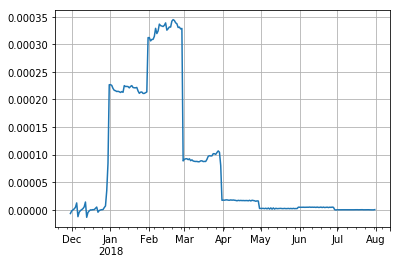

In [13]:
chg_df.FB.plot(grid=True)

TODO: validate against percentages from [M*](http://www.morningstar.co.uk/uk/funds/snapshot/snapshot.aspx?id=F00000LK2Q&tab=3)